# Simulation Evaluation

In [1]:
using AutomotiveDrivingModels
using DynamicBayesianNetworkBehaviors
using RandomForestBehaviors

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.4/AutomotiveDrivingModels.ji for module AutomotiveDrivingModels.


## Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange
dset_filepath = joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld")
dset = JLD.load(dset_filepath, "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)

ntraces = length(cv_split_outer.seg_assignment);

## Train Definitions

In [3]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "model_params.jl"))

preallocated_data_dict = preallocate_learning_data(dset, behaviorset);

## Train

In [4]:
tic()
models = train(behaviorset, dset, preallocated_data_dict, fold, cv_split_outer);
toc()

f_lat: AutomotiveDrivingModels.Features.Feature_FutureDesiredAngle()
f_lon: AutomotiveDrivingModels.Features.Feature_FutureAcceleration()
ind_lat: 1
ind_lon: 2
sym_lat: f_des_angle
sym_lon: f_accel
elapsed time: 104

104.27293896

.27293896 seconds


# Objective Evaluation

### Withheld Likelihood

In [24]:
fset_test = FoldSet(cv_split_outer, fold, true, :frame)
fset_train = FoldSet(cv_split_outer, fold, false, :frame)

model_names = collect(keys(behaviorset))
for (i,model_name) in enumerate(model_names)
    behavior = models[model_name]
    logl_train = get_score(extract(MedianLoglikelihoodMetric, dset, behavior, fset_train))
    logl_test = get_score(extract(MedianLoglikelihoodMetric, dset, behavior, fset_test))
    @printf("%30s: %15.5f  %15.5f\n", model_name, logl_train, logl_test)
end

               Static Gaussian:         3.31155          3.37683
            Mixture Regression:         7.57328          7.49186
                 Random Forest:         3.54902          3.57305
               Linear Bayesian:         9.19645          9.15826
               Linear Gaussian:         5.38978          5.34904
                Dynamic Forest:         5.30628          5.20497
              Bayesian Network:         4.08677          4.08677


# Emperical Evaluation

In [14]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_pgfplots_utils.jl"))

    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:330.
To fix, define 
    .>(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}})
before the new definition.
    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDataArray}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:285.
To fix, define 
    .>(Images.AbstractImageDirect, Union{DataArrays.DataArray, DataArrays.PooledDataArray})
before the new definition.
    .*(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:

plot_group_logl_vs_trace (generic function with 1 method)

Interact.Slider{Int64}(Signal{Int64}(4446, nactions=0),"frame",4446,1:8892,true)

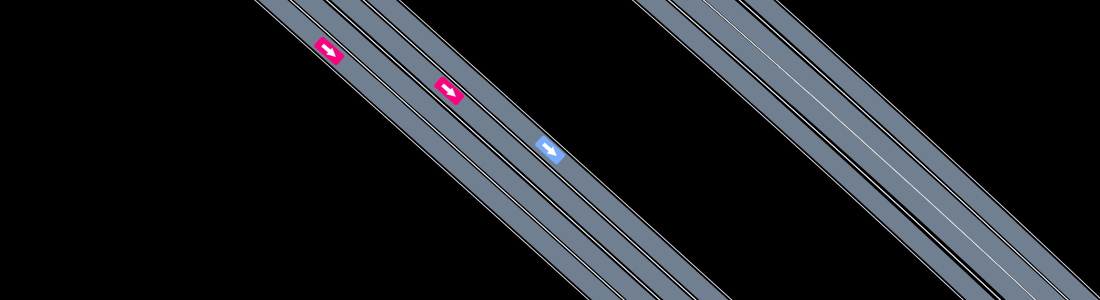

In [8]:
runlog = runlogs_original[1]
sn = streetnets[runlog.header.map_name]
plot_manipulable_runlog(runlog, sn)

In [19]:
runlogseg = dset.runlog_segments[104]
runlog = runlogs_original[runlogseg.runlog_id]
sn = streetnets[runlog.header.map_name]

seg_duration = runlogseg.frame_end - runlogseg.frame_start
where_to_start_copying_from_original_runlog = max(1, runlogseg.frame_start - DEFAULT_TRACE_HISTORY)
where_to_start_simulating_from_runlog_sim = runlogseg.frame_start - where_to_start_copying_from_original_runlog + 1
where_to_end_simulating_from_runlog_sim = where_to_start_simulating_from_runlog_sim + seg_duration

sim_runlogs = Dict{AbstractString, RunLog}()
for model_name in model_names
    behavior = models[model_name]
    runlog_sim = deepcopy(runlog, where_to_start_copying_from_original_runlog, runlogseg.frame_end)
    simulate!(runlog_sim, sn, behavior, runlogseg.carid,
              where_to_start_simulating_from_runlog_sim, where_to_end_simulating_from_runlog_sim)
    sim_runlogs[model_name] = runlog_sim
end

### Log-Likelihood vs. Trace

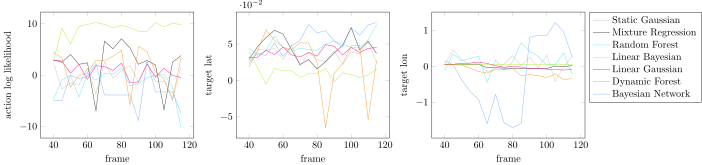

In [56]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_pgfplots_utils.jl"))
plot_group_logl_vs_trace(model_names, models, sim_runlogs, sn, 40, nframes(runlog_sim)-5, ID_EGO)

### Overlay Predictions with True Trace

Interact.Slider{Int64}(Signal{Int64}(1435, nactions=0),"frame",1435,1395:1475,true)

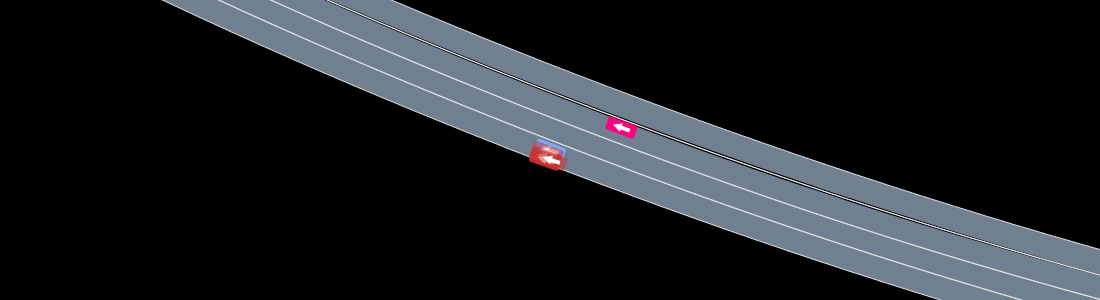

In [63]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))

overlays = Overlay[]
celloverlay = CellOverlay(CellEntry[], 10.0, 15.0, 20.0, 25.0)
push!()
for model_name in model_names
    push!(overlays, RunLogSimOverlay(sim_runlogs[model_name], 40-runlogseg.frame_start+1))
end

plot_manipulable_runlog(runlog, sn, overlays=overlays, frames=runlogseg.frame_start:runlogseg.frame_end)

### RWSE Future Distribution Display